# Species Abundance Distribution

## Week 2 - Homework

Group members:
* Amico Tommaso
* Lazzari Andrea
* Nicola Zomer

---


The aim of this notebook is to perform an analysis of the **Species Abundance Distribution (SAD)** of a dataset of species abundance in a community. 

The dataset is composed by the number of individuals (the abundance) of 4283 species, sampled in the **1%** of the total area of a forest.
The dataset is available in the file `RSA_sampled_1percent.xlsx`.

In particular, from the data of this area, we want to infer the number of species at the whole scale ($p=1$).

---

### Neutral Theory

The neutral theory of biodiversity states that the number of species in a community is proportional to the number of individuals in the community.

In fact: 
$$
 b^{i}_{n} \approx b_n 
 $$
$$
 d^{i}_{n} \approx d_n 
 $$

birth and death rates do **not** depend on the specific species identity $i$, but only on the total number of individuals $n$.

In other words all the species are equal, all the various species can be seen as a different realization of the same species, considering the dynamics is driven only by **stochasticity**.  In this sense, the evolution is only driven by a stochastic (or neutral) drift, and does not depend on the specific properties of a given species. 

Individuals are *well-mixed*, equally distributed in the community and not correlated with each other.

$$
 < n_x , n_y > \sim const
 $$

Moreover, scaling is equivalent to sampling, which means that considering a larger area corresponds to sampling more from a box. 
$$ 
Scaling  \leftrightarrow Sampling 
$$
For this reason, and given the fact that most species are rare, the **Relative Species Abundance** (RSA) is scale dependent. 

In this framework, from a small portion $a$ of the total area $A$ of the forest, we can predict the behaviour of the species ditribution at the whole scale, inferring the properties of the whole population. We call $p=a/A$ the fraction of the total forest considered. 

---


In particular, supposing we know that the total number of individuals of a species is $n$, we can compute the probability $P_p(k|n,1)$ that in a subspace at scale $p$ we find $k\leq n$ individuals. This is equal to sample $k$ individuals (over $n$ total) from a Binomial Distribution, so:

$$
P_p(k|n,1) = \binom{n}{k} p^k \cdot (1-p)^{n-k}
$$

By marginalization (over $n$, which is unknown) we obtain the probability of fining $k$ individuals at scale $p$:


$$ 
 P_p (k) = \sum_{n=1}^{\infty} P_p(k|n,1) \cdot P(n| r, \xi) = \sum_{n=1}^{\infty} \binom{n}{k} p^k \cdot (1-p)^{n-k} \cdot P(n|r, \xi)
 $$

where:
* **$p$ is the scale where we measured** 
* $r$ is a constant parameter
* $\xi = \dfrac{b}{d}$ is the ratio between birth and death rates.

Since $P(n|r, \xi)$  is a Negative Binomial Distribution, this infinite sum with binomial weights leads back to a negative binomial, making the last equation proportional to:

$$ 
P_p (k) \propto \binom{k + \hat{r}_p - 1}{k} \cdot \hat{\xi}_{p}^k \propto NegBinom(k|\hat{r}_p,\hat{\xi}_{p} )
 $$

that is again a Negative Binomial Distribution but this time with different parameters:

$$ 
\hat{r}_p = r \quad and \quad \hat{\xi}_{p} = \dfrac{\xi \cdot p}{1 - \xi(1-p)} 
$$

Due to normalization, we also have:
$$ 
\sum_{k=0}^{\infty} P_p(k) = 1
$$

Where the sum starts from $0$ because at scale $p < 1$ we do not see some species that are instead present at scale $1$. In contrast, at scale $p=1$ we see only species with at least one individual in that area. This means that $P_p(0)$ is the probability of a species to not appear in the sample, which is equal to the number of species that do not appear at scale $p$ divided by the total number of species: 

$$
P_p(0) = 1 - \sum_{k \geq 1} P_p(k) = \dfrac{S}{S} - \dfrac{S_p}{S} = \dfrac{S-S_p}{S}
$$

where $S$ is the total number of species in the forest (scale 1) and $S_p$ is the number of species in the sample (scale $p$). Doing some math we arrive to:

$$ 
S = \dfrac{S_p}{1 - P_p(0)} = S_p \cdot \dfrac{1 - (1 - \xi)^r}{1 - (1 - \hat{\xi}_p)^r} 
$$ 


Since $S_p$ is known, with some algebraic manipulation, we can infer the behaviour of the species abundance distribution (and $S$) at the whole scale $p=1$, estimating the parameter $\xi$ from $\hat{\xi}_{p}$.


---

<br>

### Procedure: moving from information at scale $p$ to information at scale $1$

The strategy for the analysis/inference is the following:

1) Compute the SAD of the sample at scale $p$ and fit a Negative Binomial distribution
2) Obtain the parameters $\hat{r}_p$, $\hat{\xi}_p$  and $S_p$ of the fitted distribution
3) Upscale the SAD to the whole scale $p=1$ using the formula above, obtaining $r$, $\xi$ and $S$.
   

## Data Analysis

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib

import xlrd
import openpyxl

In [2]:
df_species = pd.read_excel('/work/RSA_sampled_1percent.xlsx', header=0)

In [3]:
df_species

,Abundance
0,6
1,10
2,5
3,5
4,12
...,...
4278,4
4279,27
4280,2
4281,4


### RSA and SAD
We start by plotting the RSA and the SAD (which corresponds to RSA normalized to unit area) at scale $p$. 

In [4]:
bins_choice = np.arange(df_species['Abundance'].min()-0.5 , df_species['Abundance'].max()+1.5, 1)
bins_centers = (bins_choice[1:]+bins_choice[:-1])/2

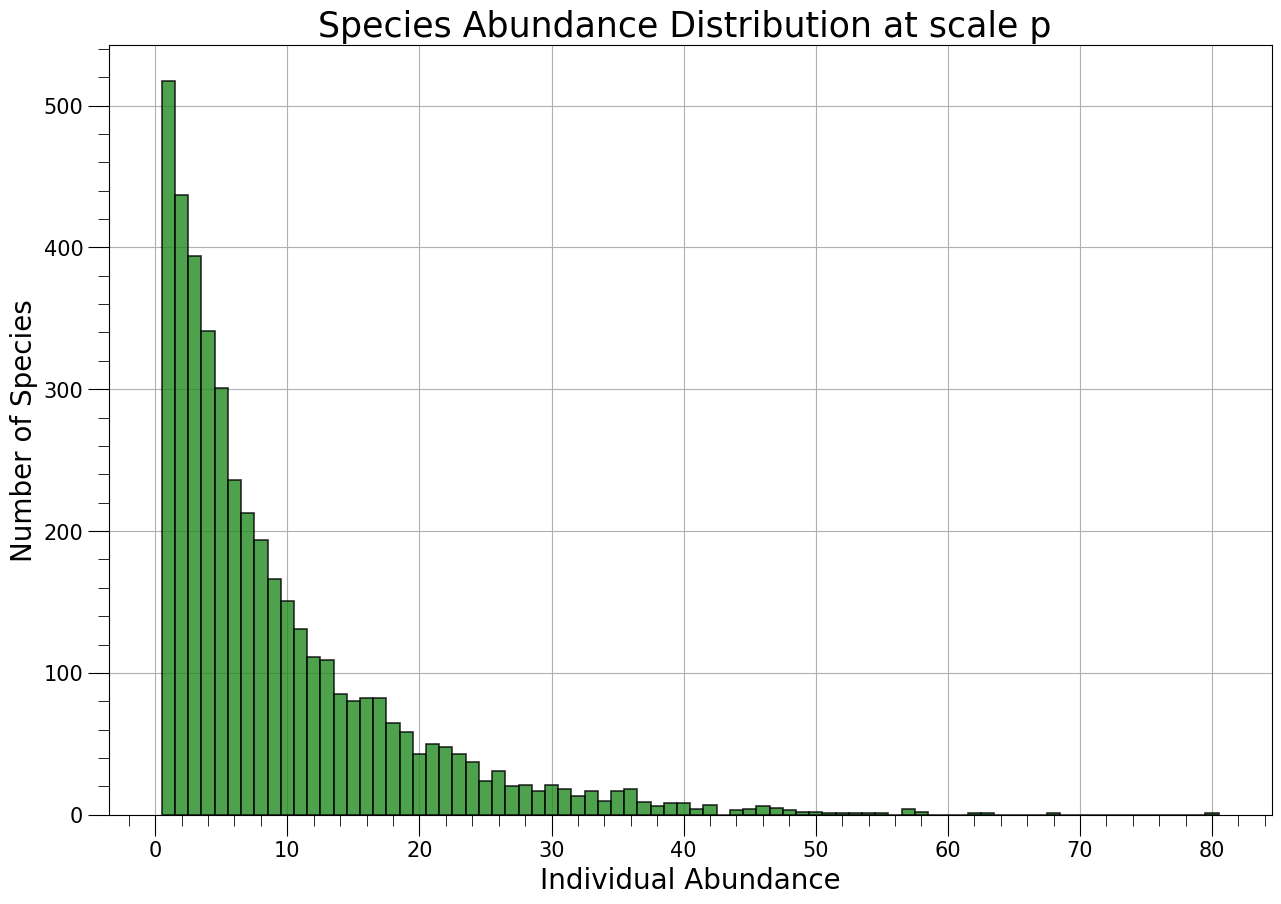

In [5]:
# plotting the species abundance distribution at scale p - NOT NORMALIZED
N_samples = np.sum(df_species['Abundance'])


fig , ax = plt.subplots(figsize=(15,10))

counts1 , edges1 , patches1 = ax.hist(df_species['Abundance'], bins=bins_choice, color='forestgreen',\
 edgecolor='black', linewidth=1.2, alpha=0.8, zorder = 2)

probabilities = np.array(counts1)/N_samples

ax.set_title('Species Abundance Distribution at scale p ', fontsize = 25)    
ax.set_xlabel('Individual Abundance', fontsize = 20)
ax.set_ylabel('Number of Species', fontsize = 20)         


ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.tick_params(axis='both', which='minor', labelsize=15, length=8)
ax.tick_params(axis='both', which='major', labelsize=15, length=15)

y_errors = np.sqrt(( probabilities * (1 - probabilities) ) / N_samples)

#ax.errorbar(x = bins_centers, y = counts1, yerr = y_errors, fmt = ' ', color = 'red', capsize = 1, elinewidth = 3)

ax.grid(zorder = 1)
ax.minorticks_on()


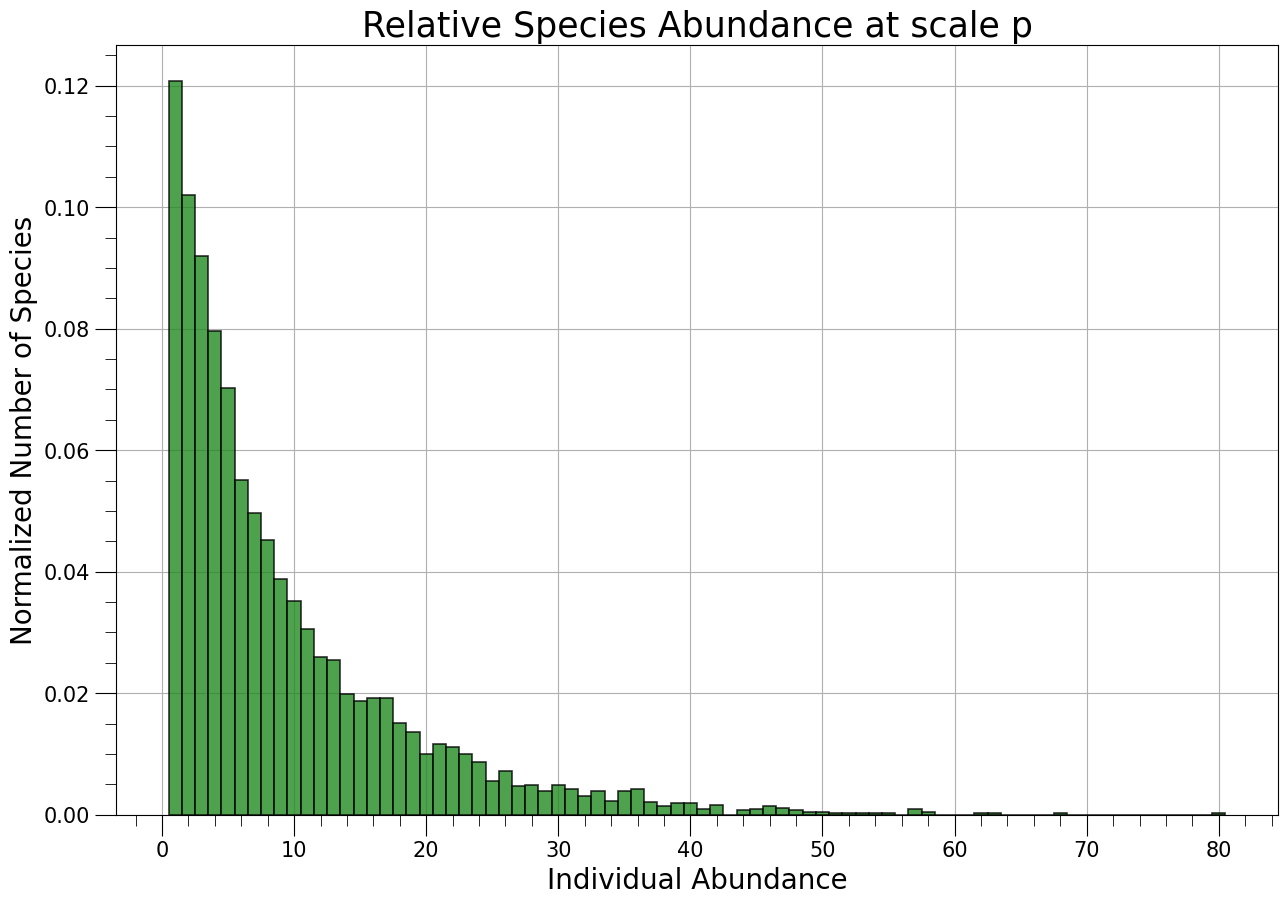

In [6]:
#this time normalized

fig , ax = plt.subplots(figsize=(15,10))


counts1 , edges1 , patches1 = ax.hist(df_species['Abundance'], bins=bins_choice, density = True,\
 color='forestgreen', edgecolor='black', linewidth=1.2, alpha=0.8, zorder = 2)
bin_centers = (edges1[:-1] + edges1[1:]) / 2

ax.set_title('Relative Species Abundance at scale p', fontsize = 25)    
ax.set_xlabel('Individual Abundance', fontsize = 20)
ax.set_ylabel('Normalized Number of Species', fontsize = 20)         


ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.tick_params(axis='both', which='minor', labelsize=15, length=8)
ax.tick_params(axis='both', which='major', labelsize=15, length=15)



ax.grid(zorder = 1)
ax.minorticks_on()

### Preston plot
Preston plot uses logarithmic binning to group bins in classes that get exponentially larger. In particular, the $i-th$ bin contains all the abundances $n\in[2^i, 2^{i+1})$. This procedure solves the problem that $P_n$ goes quickly to $0$
for $n\gg 1$, so bins are very rarefied for large $n$.

In [7]:
bins_choice_preston = [0.5] + [2**i + 0.00001   for i in range(8)]
ticks_loc = np.exp2((np.log2(bins_choice_preston[1:])+np.log2(bins_choice_preston[:-1]))/2)


bin_label = ['1'] + ['2'] + [f'{2**i + 1} - {2**(i+1)}' for i in range(1, 7)]


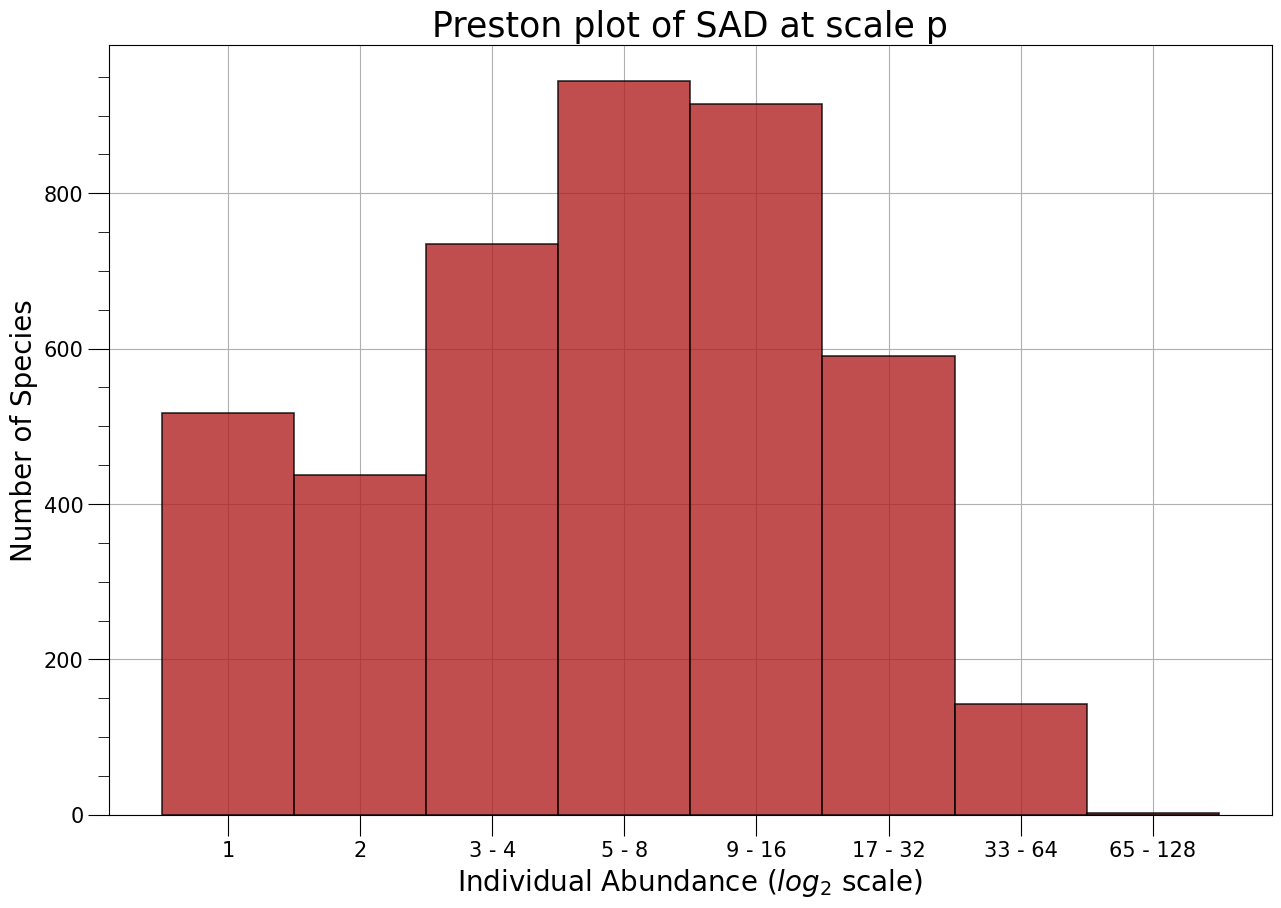

In [8]:

fig , ax = plt.subplots(figsize=(15,10))

counts2 , _ , _ = ax.hist(df_species['Abundance'], bins=bins_choice_preston, color='firebrick',\
 edgecolor='black', linewidth=1.2, alpha=0.8, zorder = 2)

ax.set_title('Preston plot of SAD at scale p', fontsize = 25)    
ax.set_xlabel('Individual Abundance ($log_2$ scale)', fontsize = 20)
ax.set_ylabel('Number of Species', fontsize = 20)         


ax.set_xscale('log', base = 2)
ax.set_xticks(ticks_loc)

ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.set_xticklabels(bin_label)
ax.tick_params(axis='both', which='minor', labelsize=15, length=8)
ax.tick_params(axis='both', which='major', labelsize=15, length=15)


ax.grid(zorder = 1)\

ax.minorticks_on()



### Fit with the Negative Binomial
The first step is to fit the RSA at scale $p$ with the Nagative Binomial distribution:
$$
    NB(k|\hat{r}_p,\hat{\xi}_{p}) = \binom{k + \hat{r}_p - 1}{k} \cdot \hat{\xi}_p^k \cdot (1-\hat{\xi}_p)^{\hat{r}_p}
$$

In [9]:
from scipy.special import binom
from scipy.stats import nbinom
from sklearn.metrics import r2_score

bins_centers = (bins_choice[1:]+bins_choice[:-1])/2

# negative binomial distribution fit
# ABUSE OF NOTATION!! Here we call p the parameter of the distribution, which corresponds to xi hat!

def negative_bin_fit(k, r , p):
    return binom(k+r-1, k ) * p**k * (1-p)**r


In [10]:
import scipy as scp
from scipy.optimize import curve_fit

popt, pcov = scp.optimize.curve_fit(negative_bin_fit, xdata=bins_centers,  ydata = counts1)


In [11]:
print(f'''The result of the fit for the parameters r, p are: 
r = {popt[0]:.2f} ± {np.sqrt(pcov[0, 0]):.2f}
and
p = {popt[1]:.3f} ± {np.sqrt(pcov[1, 1]):.3f}''')

print('\nScore:', r2_score( counts1,  negative_bin_fit(bins_choice[:-1]+0.5, popt[0], popt[1])))
#print('\nScore:', r2_score( counts1,  negative_bin_scipy(bins_choice[:-1]+0.5, popt[0], popt[1])))


The result of the fit for the parameters r, p are: 
r = 1.05 ± 0.03
and
p = 0.862 ± 0.005

Score: 0.9896194808166406


We can try to fit the distribution also using the $logseries$:

In [12]:
def logseries(k, a, p):
    return a*(p**k)/k

popt_log, pcov_log = scp.optimize.curve_fit(logseries, xdata=bins_centers,  ydata = counts1)

print(f'''The result of the fit for the parameters a, p are: 
a = {popt_log[0]:.2f} ± {np.sqrt(pcov[0, 0]):.2f}
and
p = {popt_log[1]:.3f} ± {np.sqrt(pcov[1, 1]):.3f}''')

The result of the fit for the parameters a, p are: 
a = 0.17 ± 0.03
and
p = 1.006 ± 0.005


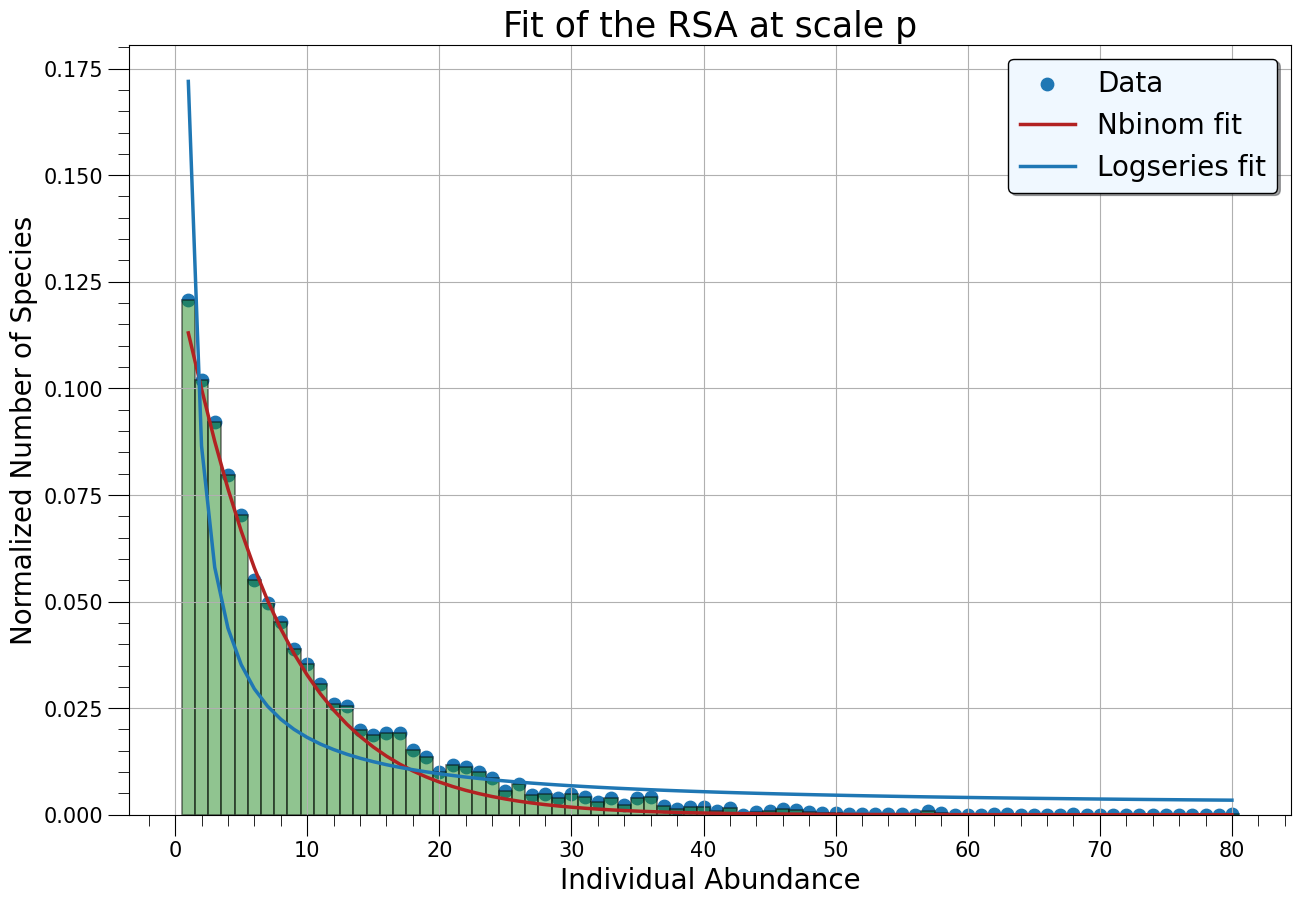

In [13]:
fig , ax = plt.subplots(figsize=(15,10))

ax.scatter(bins_centers, counts1, s=80, label='Data')
ax.hist(df_species['Abundance'], bins=bins_choice, density = True, color='forestgreen', edgecolor='black', linewidth=1.2, alpha=0.5)
ax.plot(bin_centers, negative_bin_fit(bin_centers,popt[0], popt[1]), color='firebrick',\
 label='Nbinom fit', linewidth = 2.5)
ax.plot(bin_centers, logseries(bin_centers,popt_log[0], popt_log[1]), color='C0',\
 label='Logseries fit', linewidth = 2.5)

ax.set_title('Fit of the RSA at scale p', fontsize = 25)    
ax.set_xlabel('Individual Abundance', fontsize = 20)
ax.set_ylabel('Normalized Number of Species', fontsize = 20)         

ax.legend(shadow=True, edgecolor='black', facecolor='aliceblue', fontsize=20 , loc ='best')


ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.tick_params(axis='both', which='minor', labelsize=15, length=8)
ax.tick_params(axis='both', which='major', labelsize=15, length=15)


ax.grid(zorder = 1)
ax.minorticks_on()

### Parameters values at scale $1$
To sum up what we did up to now, we fitted the Negative Binomial (**NB**) at scale $p = \dfrac{1}{100}$, inferring the paramteters $\hat{r}_p$ and $\hat{\xi}_p$.
As said above, $\hat{r}_p$ and $\hat{\xi}_p$ are related to the Negative Binomial at scale $p = 1$ by the relationships:

$$

\hat{r}_p = r \quad, \quad \hat{\xi}_p = \dfrac{p \cdot \xi}{1 - \xi(1 - p)}

$$

And the number of species at scale $p = 1$ is given by:
$$
S = \dfrac{S_p}{1 - P_p(0)} = S_p \cdot \dfrac{1 - (1 - \xi)^r}{1 - (1 - \hat{\xi}_p)^r}
$$

Inverting the relationship between $\hat{\xi}_p$ and $\xi$ we obtain,

$$

\xi \quad = \quad \dfrac{\hat{\xi}_p}{p + \hat{\xi}_p \cdot (1 - p)}

$$

We are now ready to estimate $r$, $\xi$ and the total population $S$.


In [14]:
#r = popt[0]
r = popt[0]
xi_hat = popt[1]

sp = len(df_species)

p = 1/100

xi = xi_hat / (p + xi_hat * (1 - p) )

print(f'''The inferred parameters at scale 1 are: 
r = {r:.4f} 
and
xi = {xi:.5f} ''')

The inferred parameters at scale 1 are: 
r = 1.0509 
and
xi = 0.99840 


We can now plot the Negative Binomial Distribution both at scale $p$ and $1$.

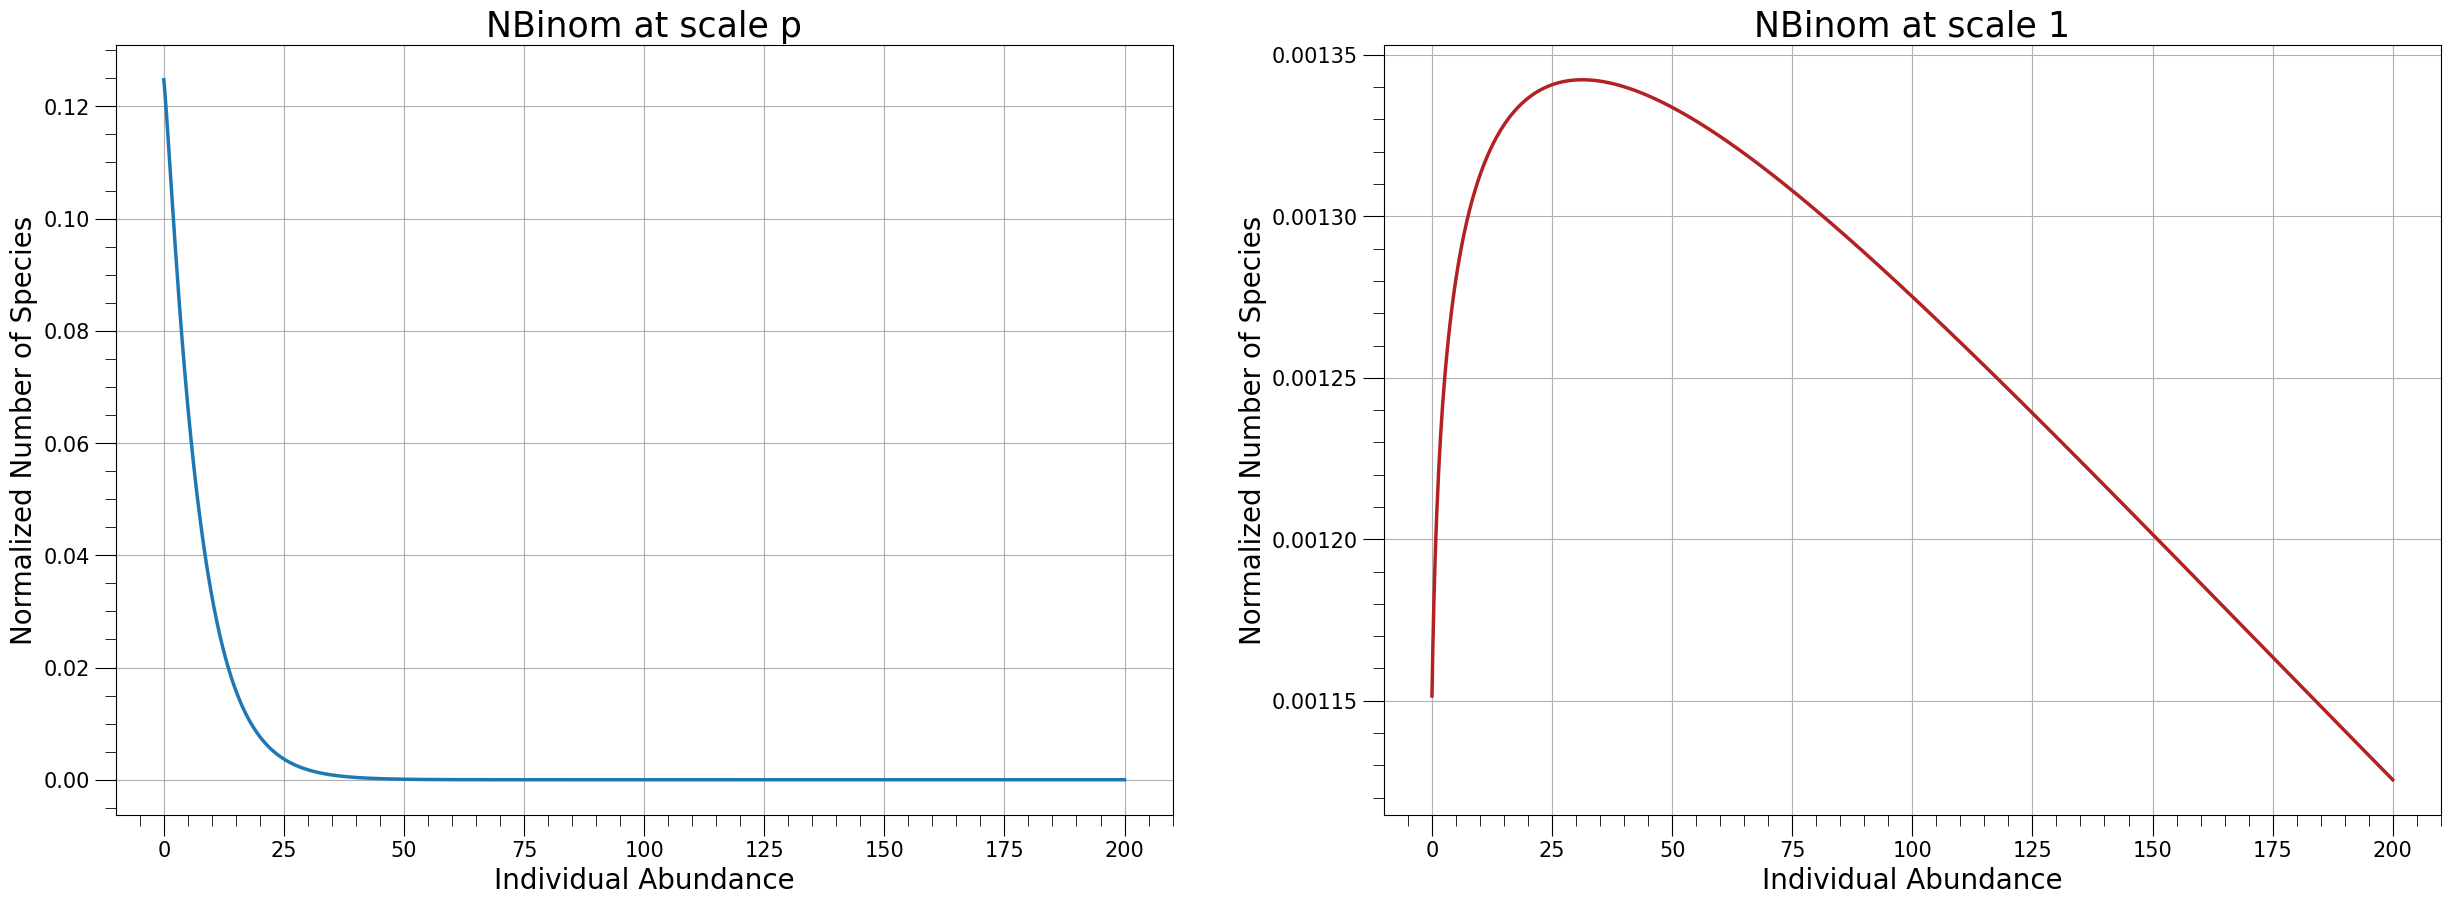

In [ ]:
individuals = np.linspace(0, 200, 1000)

fig , ax = plt.subplots(1, 2, figsize=(30,10))

ax[0].plot(individuals, negative_bin_fit(individuals,popt[0], popt[1]), color='C0', linewidth = 2.5)
ax[1].plot(individuals, negative_bin_fit(individuals, r, xi), color='firebrick', linewidth = 2.5)


# fig.suptitle('Estimated RSA', fontsize=25)
ax[0].set_title('NBinom at scale p', fontsize = 25)   
ax[1].set_title('NBinom at scale 1', fontsize = 25)

for i in range(2):
    ax[i].set_xlabel('Individual Abundance', fontsize = 20)
    ax[i].set_ylabel('Normalized Number of Species', fontsize = 20)        

    ax[i].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax[i].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

    ax[i].get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

    ax[i].tick_params(axis='both', which='minor', labelsize=15, length=8)
    ax[i].tick_params(axis='both', which='major', labelsize=15, length=15)

    ax[i].grid(zorder = 1)
    ax[i].minorticks_on()

plt.show()

### Number of species in the forest

In [17]:
s = sp *  (( 1 - ( 1 - xi )**r ) / ( 1 - ( 1 - xi_hat )**r ))
print(f'''The estimated number of species in the whole forest is S={int(s)}''' )

The estimated number of species in the whole forest is S=4887


---

## Estimating $p_{pred}$

In the following section we want to verify if the fraction of the forest $p = \dfrac{1}{100}$ investigated, that we will now call $p^*$, is too little or too high and we wasted our resources.

We want to establish this by an iterative procedure. Given our estimate of $S$, called from now on $S^*$, we will downsample to $p^*$. After that we are going to upscale again to retrieve a new estimate $S^{'}$ (the procedure will be done many times to consider the average behaviour).


If $S^{'}$ will be consistent with $S^*$ we would be confident about our estimation. If the latter does not happen we are going to change the downscaling value of $p$ accordingly and repeat the procedure.

In [18]:
def acceptance_rejection_sampling(n_samples, n_failures, p):
    """Acceptance-rejection sampling for the negative binomial distribution.
    
    Parameters
    ----------
    n_samples : int
        Number of samples to draw.
    n_failures : int                                                #our r
        Number of failures before the experiment is stopped.
    p : float                                                       #our xi
        Probability of success in each trial.
        
    Returns
    -------
    samples : numpy.ndarray
        Samples from the negative binomial distribution.
    """

    samples = np.zeros(n_samples)
    for i in range(n_samples):
        while True:
            x = np.random.uniform(low = 0, high = 200)
            u = np.random.uniform(0, 1)
            if u*negative_bin_fit( ((n_failures - 1)*p)/(1-p), n_failures, p ) <=\
             negative_bin_fit(x, n_failures, p) :  
                samples[i] = x
                break
    return samples

    

In [19]:
def down_up_scaling(p, r, xi, size):
    

    xi_tilde_ = ( p * xi ) / ( 1 - xi * (1 - p) )     #down-scaling
    

   
    simulated_nb = acceptance_rejection_sampling(n_samples = size , n_failures = r, p = xi_tilde_)  #sampling from scale p
    


    simulated_nb = simulated_nb.astype(int)

    bins_choice = np.arange(simulated_nb.min()-0.5 , simulated_nb.max()+1.5, 1)

    counts_ , _ = np.histogram(simulated_nb, bins = bins_choice)      #SAD

    sp = np.sum(counts_)

    counts, edges = np.histogram(simulated_nb, bins = bins_choice, density = True)   #RAD

    bin_centers_ = (bins_choice[1:] + bins_choice[:-1])/2

    popt, pcov = scp.optimize.curve_fit(negative_bin_fit, xdata=bin_centers_, ydata = counts)   #fit to up-scale


    r_new = popt[0]                    #parameters
    xi_tilde_new = popt[1]


    xi_new = xi_tilde_new / (p + xi_tilde_new * (1 - p) )    


    s =  sp * ( ( 1 - ( 1 - xi_new )**r_new ) / ( 1 - ( 1 - xi_tilde_new )**r_new ))    #up-scaling

    
    return s



In [47]:
def find_p_pred(species_estimated, p_initial, r, xi, N_generated):

    boundary_top = species_estimated + (5 * species_estimated)/100
    boundary_bottom = species_estimated - (5 * species_estimated)/100

    p_pred = p_initial
    
    global all_sizes
    all_sizes = []

    while True:
        
        arguments = [p_pred, r, xi, 4887]
        sizes = np.zeros(N_generated)

        for i in range(N_generated):
            sizes[i] = down_up_scaling(*arguments)

        sizes = sizes.astype(int)

        all_sizes.append(sizes)

        n_species_est = np.mean(sizes)

        n_species_std = np.std(sizes)
        
        print(f'\nWith respect to {species_estimated} measured species at scale 1')
        print(f'The number of species estimated at scale p {p_pred * 100:.2f} % is {int(n_species_est)} ± {int(n_species_std)}')
        
        if boundary_bottom <  n_species_est    < boundary_top:
            final_p = p_pred/p_initial
            break
            
        p_pred += 1/100

    return (final_ratio, n_species_est, n_species_std)


In [49]:
final_ratio, n_species_est, n_species_std = find_p_pred(s, 1/100, r, xi, 50)


With respect to 4887 measured species at scale 1
The number of species estimated at scale p 1.00 % is 5597 ± 25

With respect to 4887 measured species at scale 1
The number of species estimated at scale p 2.00 % is 5226 ± 13

With respect to 4887 measured species at scale 1
The number of species estimated at scale p 3.00 % is 5105 ± 10


In [81]:
def boxplot(y, colors, figsize=(15,10), linewidth=2, color_median='black', linewidth_median = 1,\
 size_props = 12, title = 'Boxplot', font_title = 20, xlabel='x_axis', x_font=15,\
  ylabel='y_axis', y_font=15, labels=False, list_labels=[] ):

    fig, ax = plt.subplots(1,1,figsize=figsize)

    bp = ax.boxplot(y,boxprops=dict(linewidth=linewidth), patch_artist=True,\
     medianprops=dict(color=color_median, linewidth=linewidth_median), flierprops=dict(markersize=size_props))


    ax.set_title(title, fontsize=font_title)


    ax.set_xlabel(xlabel, fontsize=x_font)
    ax.set_ylabel(ylabel, fontsize=y_font)


    for array, x_point, color in zip(y, range(1, len(y)+1), colors) :
        tmp = np.ones([len(array),])*x_point + 0.35
        ax.scatter(tmp, array, s=77, alpha=0.5, edgecolor='black', color=color)

    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)


    ax.minorticks_on()
    ax.xaxis.set_tick_params(which='minor', bottom=False , size=10)
    ax.yaxis.set_tick_params(labelsize=14, size=10)
    

    if labels:
        ax.set_xticklabels(list_labels)


    return fig, ax



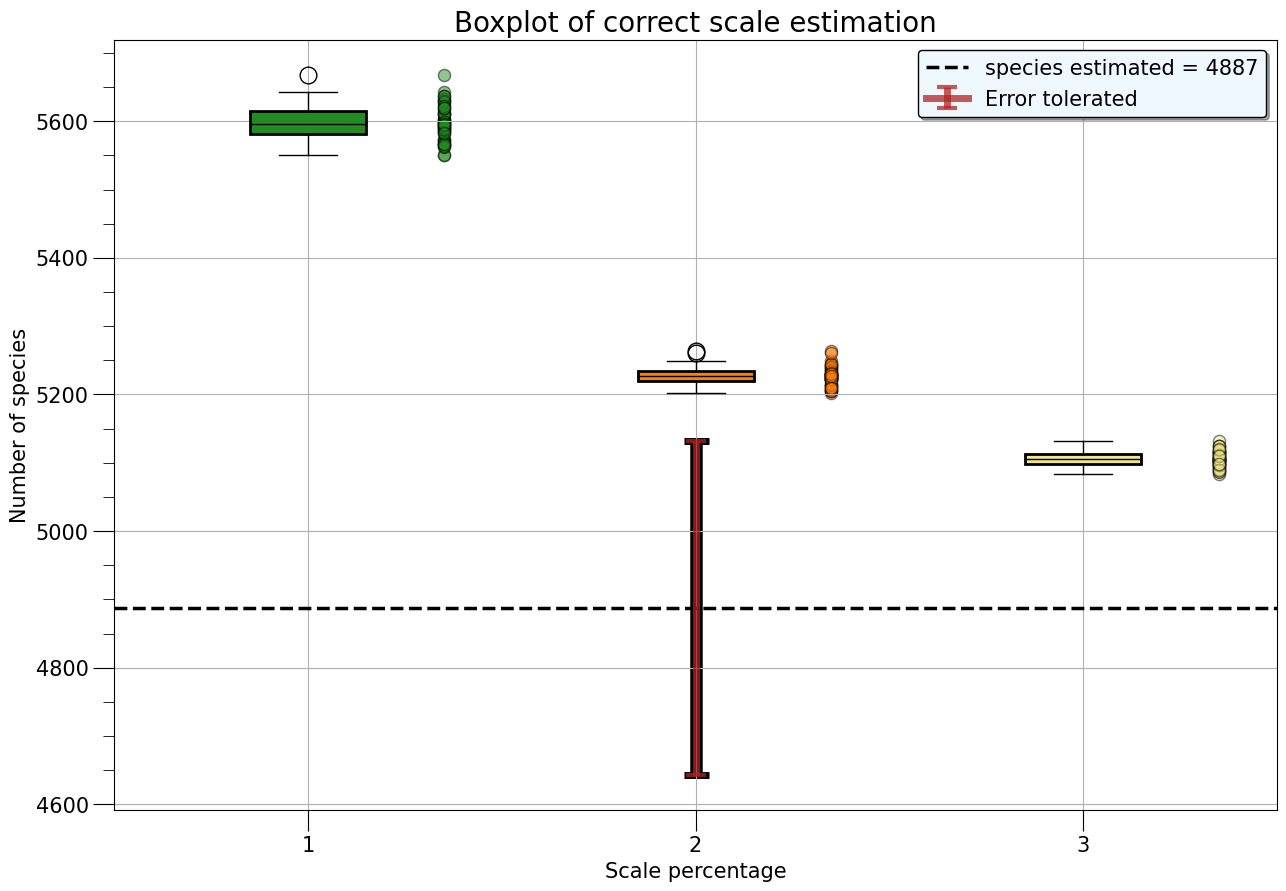

In [88]:
fig, ax = boxplot(all_sizes, ['forestgreen', 'C1' , 'khaki'],\
title ='Boxplot of correct scale estimation', ylabel = 'Number of species',\
 xlabel = 'Scale percentage')

ax.axhline(s, color = 'black', linestyle = '--', linewidth = 2.5, label = f'species estimated = {int(s)}')
ax.errorbar(2, s, yerr = s*5/100, capsize=7, capthick=3, linewidth = 5, color = 'firebrick',\
zorder = 2, label = 'Error tolerated', alpha=0.75)

ax.errorbar(2, s, yerr = s*5/100, capsize=9, capthick=5, linewidth = 9, color = 'black',\
zorder = 1)


ax.grid(zorder = 0)

ax.legend(facecolor = 'aliceblue', shadow = True, edgecolor = 'black', fontsize = 15)

ax.tick_params(axis='both', which='minor', labelsize=15, length=8)
ax.tick_params(axis='both', which='major', labelsize=15, length=15)



As confidence interval in this estimate, we choose to tolerate an error of 5%:
$$
4662   \quad <  \quad 5105  \text{  species} \quad < \quad 5131
$$
finding $p_{pred} = 3 \%$.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=73bb81e5-9682-4077-8f84-f8164416e221' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>